In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, MaxPooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape the images to add a dimension for the channel
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_cnn = x_test.reshape(x_test.shape[0], 28, 28, 1)

y_train.shape, y_test.shape, x_train_cnn.shape, x_test_cnn.shape

((60000, 10), (10000, 10), (60000, 28, 28, 1), (10000, 28, 28, 1))

In [3]:
import random
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2

/Users/oscarmoxon/anaconda3/envs/NN/lib/python3.11/site-packages/keras/preprocessing/image.py:1460: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, which overrides setting of `featurewise_center`.
  warnings.warn(


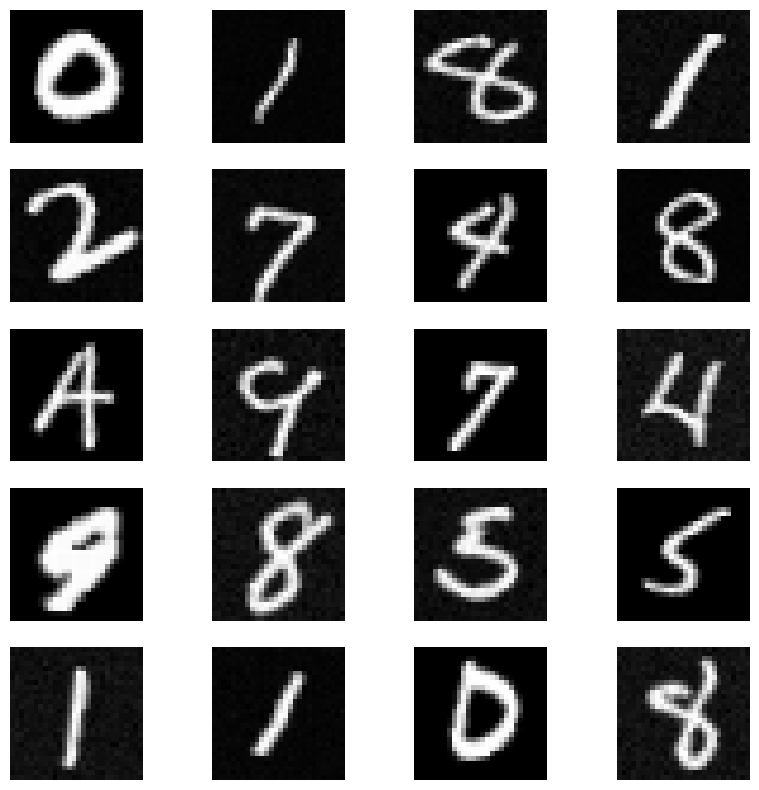

In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import math
import tensorflow as tf

def random_gaussian_noise(x):
    if random.random() < 0.5:  # 50% chance to add Gaussian noise
        scale = np.random.uniform(0.025, 0.000005)
        return x + np.random.normal(loc=0, scale=scale, size=x.shape)
    else:
        return x

datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    shear_range=1,
    horizontal_flip=False,
    fill_mode='nearest',
    featurewise_std_normalization=True,  # Normalize the dataset
    preprocessing_function=random_gaussian_noise  # Add Gaussian noise
)

# Fit the data augmentation on the combined training dataset
datagen.fit(x_train_cnn)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_cnn, y_train, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()



# Define the CNN model
cnn_model_9 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.001)), 
                                           # Input shape: this is the shape of one image, it has 1 dimension (greyscale)
    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Conv2D(64, kernel_size=(5, 5), activation='relu', kernel_regularizer=l2(0.001)), 
                                           # Input shape: this is the shape of one image, it has 1 dimension (greyscale)
    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)), # This layer applies 32 differnt filters (each 3 x 3), each filter extracts different features (edges, corners, etc.)
                                           # ReLU activation is used to introduce non-linearity, allowing the model to learn more complex patterns. 
    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Flatten(),                             # This layer flattens the 2D feature maps into a 1D vector, which can be used as input to a fully connected neural network.

    Dense(256, activation='relu'),         # This layer has 256 neurons and uses ReLU activation.
    Dropout(0.5),                          # Regularisation technique where randomly selected neurons are ignored during training. This helps prevent overfitting.

    Dense(10, activation='softmax')        # This layer has 10 neurons and uses softmax activation. Softmax activation enables you to calculate probabilities for each class score.
])


# Learning Rate Scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Stop after 3 epochs of no improvement
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # Stop when the quantity monitored has stopped decreasing
    verbose=1,
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

# Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

# Compile the model (example, adjust as needed)
cnn_model_9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
cnn_model_9.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)        0

In [6]:
# Assuming x_train_cnn and y_train are your full training dataset and labels
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_cnn, y_train, test_size=0.2, random_state=42)

x_train_split.shape, x_val_split.shape, y_train_split.shape, y_val_split.shape

((48000, 28, 28, 1), (12000, 28, 28, 1), (48000, 10), (12000, 10))

Epoch 1/15


2024-02-19 18:09:43.536451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-02-19 18:09:43.542397: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


187/188 [============================>.] - ETA: 0s - loss: 0.5763 - accuracy: 0.8539

2024-02-19 18:09:50.585549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


188/188 [==============================] - 8s 39ms/step - loss: 0.5750 - accuracy: 0.8543 - val_loss: 0.2001 - val_accuracy: 0.9725
Epoch 2/15
188/188 [==============================] - 7s 39ms/step - loss: 0.2267 - accuracy: 0.9638 - val_loss: 0.1534 - val_accuracy: 0.9841
Epoch 3/15
188/188 [==============================] - 7s 40ms/step - loss: 0.1810 - accuracy: 0.9737 - val_loss: 0.1427 - val_accuracy: 0.9842
Epoch 4/15
188/188 [==============================] - 7s 39ms/step - loss: 0.1554 - accuracy: 0.9787 - val_loss: 0.1192 - val_accuracy: 0.9879
Epoch 5/15
188/188 [==============================] - 7s 36ms/step - loss: 0.1377 - accuracy: 0.9810 - val_loss: 0.1100 - val_accuracy: 0.9879
Epoch 6/15
188/188 [==============================] - 7s 39ms/step - loss: 0.1247 - accuracy: 0.9826 - val_loss: 0.1007 - val_accuracy: 0.9880
Epoch 7/15
188/188 [==============================] - 7s 38ms/step - loss: 0.1159 - accuracy: 0.9837 - val_loss: 0.1009 - val_accuracy: 0.9881
Epoch 8/15

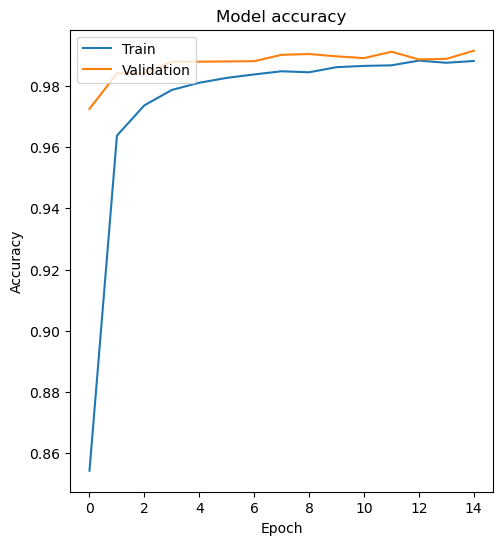

In [7]:
# Assuming x_train_cnn and y_train are your full training dataset and labels
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_train_cnn, y_train, test_size=0.2, random_state=42)

# Create a new ImageDataGenerator instance for validation (without data augmentation)
validation_datagen = ImageDataGenerator(featurewise_std_normalization=True)

# Fit the validation_datagen on the validation data
validation_datagen.fit(x_val_split)

# Create the data generators
train_generator = datagen.flow(x_train_split, y_train_split, batch_size=256)
validation_generator = validation_datagen.flow(x_val_split, y_val_split, batch_size=256)

# Train the CNN model using augmented data
cnn_history_9 = cnn_model_9.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator  # Assuming x_val and y_val are already defined and preprocessed
)

# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history_9.history['accuracy'])
plt.plot(cnn_history_9.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [8]:
import matplotlib.pyplot as plt
import numpy as np

In [9]:
# Evaluate CNN model
cnn_loss, cnn_accuracy = cnn_model_9.evaluate(x_test_cnn, y_test)
print("CNN Test Accuracy:", cnn_accuracy)

313/313 [==============================] - 1s 3ms/step - loss: 0.2613 - accuracy: 0.9899
CNN Test Accuracy: 0.9898999929428101


313/313 [==============================] - 1s 2ms/step
Displaying first 36 out of 101 misclassified examples.


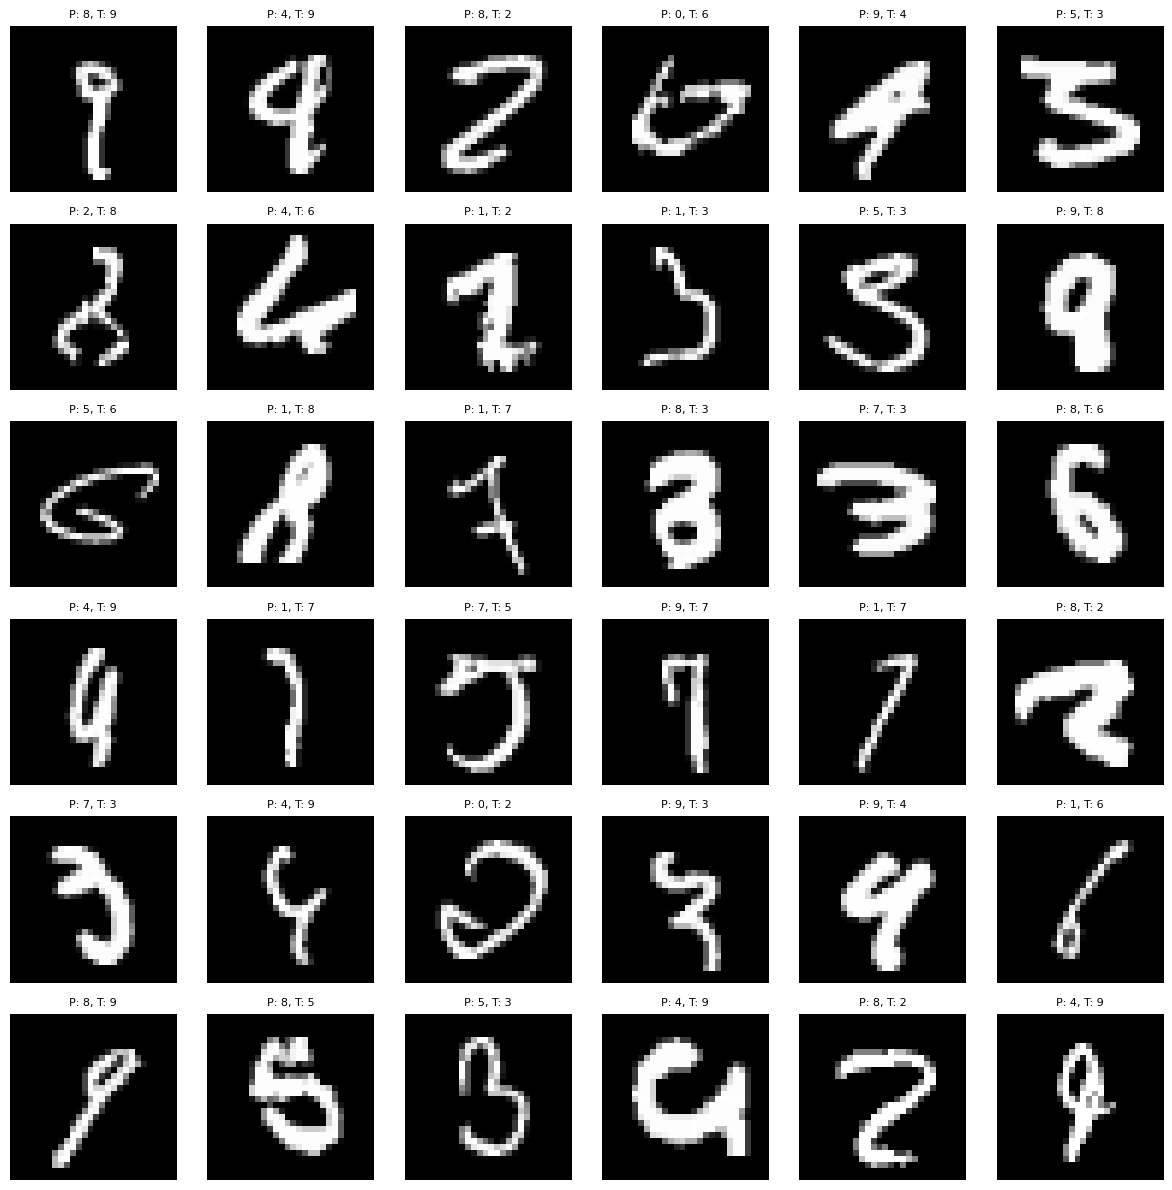

In [10]:
# Predict the labels for the test set
y_pred = cnn_model_9.predict(x_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Identify the indices of misclassified examples
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Function to visualize misclassified examples
def plot_misclassified(indexes, y_pred_classes, y_true, images, rows=6, cols=6):
    """Plots a selection of the misclassified images in grid format."""
    n = len(indexes)
    if n > rows*cols:
        print(f"Displaying first {rows*cols} out of {n} misclassified examples.")
        n = rows*cols
    
    plt.figure(figsize=(2*cols, 2*rows))
    for i in range(n):
        idx = indexes[i]
        plt.subplot(rows, cols, i+1)
        plt.imshow(images[idx].reshape(28, 28), cmap='gray')
        plt.title(f"P: {y_pred_classes[idx]}, T: {y_true[idx]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize first few misclassified examples
plot_misclassified(misclassified_indices, y_pred_classes, y_true, x_test)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
print(confusion_matrix(y_true, y_pred_classes))

# Classification Report
print(classification_report(y_true, y_pred_classes))

[[ 976    1    0    0    1    0    0    1    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   2    2 1005    0    0    0    0   12   11    0]
 [   0    1    1  995    0    6    0    2    4    1]
 [   0    0    0    0  976    0    0    0    0    6]
 [   0    0    0    2    0  886    1    1    1    1]
 [   1    4    0    0    2    2  945    0    4    0]
 [   0    8    0    0    0    0    0 1015    1    4]
 [   0    1    1    0    0    0    0    0  970    2]
 [   0    1    0    0    6    0    0    2    4  996]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.98      1.00      0.99      1135
           2       1.00      0.97      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.98      0.99   

EMNIST validation training

In [12]:
from emnist import extract_training_samples, extract_test_samples
from sklearn.metrics import precision_score, recall_score, f1_score

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding
emnist_labels = to_categorical(emnist_labels, 10)
emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_test_images.shape

((240000, 28, 28, 1), (40000, 28, 28, 1))

In [14]:
# Evaluate the model on EMNIST test images
emnist_loss, emnist_accuracy = cnn_model_9.evaluate(emnist_test_images, emnist_test_labels)
print("EMNIST Test Accuracy:", emnist_accuracy)

1250/1250 [==============================] - 3s 2ms/step - loss: 0.4666 - accuracy: 0.9616
EMNIST Test Accuracy: 0.9616249799728394


In [16]:
# Predict the labels for the EMNIST test set
emnist_predictions = cnn_model_9.predict(emnist_test_images)
emnist_pred_classes = np.argmax(emnist_predictions, axis=1)
emnist_true_classes = np.argmax(emnist_test_labels, axis=1)

# Calculate precision, recall, and F1 score
emnist_precision = precision_score(emnist_true_classes, emnist_pred_classes, average='weighted', zero_division=0)
emnist_recall = recall_score(emnist_true_classes, emnist_pred_classes, average='weighted', zero_division=0)
emnist_f1 = f1_score(emnist_true_classes, emnist_pred_classes, average='weighted', zero_division=0)

print("Precision:", emnist_precision)
print("Recall:", emnist_recall)
print("F1 Score:", emnist_f1)

1250/1250 [==============================] - 3s 2ms/step
Precision: 0.964426272348713
Recall: 0.961625
F1 Score: 0.961849265176061


In [17]:
import numpy as np
import os
from tensorflow.keras.models import load_model

In [20]:
#load .h5 file of arbitrary name for testing (last if more than one)
# Get the current working directory
current_directory = os.getcwd()

# Specify the filename you care about
file_name = "cnn_model_9.h5"

# Construct the full path to the file
file_path = os.path.join(current_directory, file_name)

# Check if the file exists
if os.path.exists(file_path):
    # Load the model from the specified file
    net = load_model(file_path)
    
    # Print the summary of the loaded model
    net.summary()
else:
    print(f"The file {file_name} does not exist in the current directory.")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [21]:
#determine what type of network this is
conf=net.layers[0].get_config()
inshape=conf['batch_input_shape']
if inshape[1]==28:
    netType='CNN'
else:
    netType='MLP'

In [23]:
#test with MNIST data
from tensorflow.keras.datasets import mnist

(x_train, labels_train), (x_test, labels_test) = mnist.load_data()
x_test = x_test.astype('float32')
x_test /= 255

if netType in ['MLP']:
    x_test = x_test.reshape(10000, 784)
else:
    x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

outputs=net.predict(x_test)
labels_predicted=np.argmax(outputs, axis=1)
correct_classified=sum(labels_predicted==labels_test)

print('Percentage correctly classified MNIST=',100*correct_classified/labels_test.size)

313/313 [==============================] - 1s 2ms/step
Percentage correctly classified MNIST= 98.93
